# Model inference with pretrained models

In [1]:
import numpy as np
import torch
from swincell.utils.utils import load_model
from swincell.utils.utils import load_default_config
from swincell.cellpose_dynamics import compute_masks
# from swincell.utils.data_utils import flow_reshaped, split_dataset


/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configure inference parameters

In [62]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '../../Nanolive_demo/'

args =load_default_config()
args.data_dir=data_dir
args.dataset = 'nanolive'

# args.pretrained_model_name = '../../pretrained_models/colon_model.pt'
# args.pretrained_model_name = '../../pretrained_models/nanolive_model.pt'
args.pretrained_model_name = '../../pretrained_models/nanolive_v5_swinunet_cellpose.pt'
# args.pretrained_model_name = '../../pretrained_models/nanolive_v6_swinunet_cellpose.pt'

In [63]:
model = load_model(args).to(device)
model_dict = torch.load(args.pretrained_model_name)["state_dict"]
model.load_state_dict(model_dict)

<All keys matched successfully>

In [64]:
# configuration to segment colon
from natsort import natsorted
import glob
import os


model_input_ROI = (128,128,32)
infer_ROI = (256,256,32)
# infer_ROI = (128,128,32)

# model_type = 'swin'

a_min = 1
a_max = 255
# a_max = 100
# a_min = 18000
# a_max = 31000
dsp =1

min_size = 50*50

output_dir ='../../results/test_inference_'+ args.model
print(output_dir)
#if output_dir not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#images to predict
img_full_paths = natsorted(glob.glob(data_dir+'images/*.tif*'))
print(len(img_full_paths))
print(img_full_paths)

../../results/test_inference_swin
5
['../../Nanolive_demo/images/12_RI_time00h00m00s.tiff', '../../Nanolive_demo/images/15_RI_time00h00m00s.tiff', '../../Nanolive_demo/images/16_RI_time00h00m00s.tiff', '../../Nanolive_demo/images/17_RI_time00h00m00s.tiff', '../../Nanolive_demo/images/31_RI_time00h00m00s.tiff']


In [65]:
from swincell.utils.data_utils import split_dataset
split_dataset_inference = True
if split_dataset_inference:

    _, _, inference_datalist = split_dataset(data_dir, split_ratios=[0.0,0.0,1.0]) 
else:
    inference_datalist = img_full_paths
print(len(inference_datalist))


5


In [66]:
from monai import data, transforms

if args.dataset =='nanolive':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(512//dsp,512//dsp,96//dsp))
elif args.dataset =='colon':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(1200//dsp,960//dsp,128//dsp))
elif args.dataset =='allen':
    transform_resize = transforms.Resized(keys=["image"],spatial_size=(900//dsp,600//dsp,64//dsp)),
else:
    raise Warning("dataset not defined")
if args.dataset =='nanolive':
    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transform_resize,
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=a_min, a_max=a_max, b_min=0, b_max=1, clip=True
            ),
            transforms.ToTensord(keys=["image"]),
        ]
    )
else:
    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            # transforms.Resized(keys=["image"],spatial_size=(512//dsp,512//dsp,96//dsp)),
            transforms.ScaleIntensityRanged(
                # keys=["image"], a_min=17000, a_max=29000, b_min=0, b_max=1, clip=True
                keys=["image"], a_min=a_min, a_max=a_max, b_min=0, b_max=1, clip=True
            ),
            transforms.ToTensord(keys=["image"]),
        ]
    )


test_ds = data.Dataset(data= inference_datalist[:1], transform=test_transform)
# test_loader = data.DataLoader(
#         test_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
#     )
test_loader = data.DataLoader(
        test_ds, batch_size=1, sampler=None, drop_last=True
    )

args.dataset

'nanolive'

In [60]:
# model = load_model(args).to(device)



In [67]:
from monai.transforms import (
    AsDiscrete,
    Activations,
)
from functools import partial
from monai.inferers import sliding_window_inference
import tifffile

model_inferer = partial(
    sliding_window_inference,
    roi_size=infer_ROI,
    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
    mode='gaussian'
)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            out_filename = inference_datalist[idx]['image'].split('.')[0].split('/')[-1] +'_pred.tiff' 
            data_test = batch_data["image"]
            data_test = data_test.cuda(device)
            logits = model_inferer(data_test)

            
            print(out_filename)
            logits_out =  np.squeeze(logits.detach().cpu().numpy())
            
            print('logits shape',logits_out.shape)

            # logits_out =np.float32(logits_out)
            logits_out = np.transpose(logits_out,(0,3,2,1))

            tifffile.imwrite(output_dir +'/logits_'+out_filename ,logits_out)
            # print('cell prob ', logits[0].max(),logits[0].min())
            # logits_out[0] = np.uint8(logits_out[0]>0)
            #
            # logits_out[0] = post_pred(post_sigmoid(logits_out[0]))
            # # masks_recon,p = compute_masks(logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.0,flow_threshold=0, do_3D=True)
            # masks_recon,p = compute_masks(10*logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.4,flow_threshold=0.4, do_3D=True,min_size=min_size, use_gpu=True)
            
            
            # tifffile.imwrite(output_dir +'/mask_size_'+str(round(min_size))+'_'+out_filename ,masks_recon)

            print(logits.shape, logits.max(),logits.min())

_pred.tiff
logits shape (4, 512, 512, 96)
torch.Size([1, 4, 512, 512, 96]) metatensor(53.4563, device='cuda:0') metatensor(-313.1399, device='cuda:0')


In [ ]:
logits_out[0] = np.uint8(logits_out[0]>0)
masks_recon,p = compute_masks(10*logits_out[1:4,:,:,:],logits_out[0,:,:,:],cellprob_threshold=0.4,flow_threshold=0.4, do_3D=True,min_size=min_size, use_gpu=True)
tifffile.imwrite(output_dir +'/mask_size_'+str(round(min_size))+'_'+out_filename ,masks_recon)

## visualize inference results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


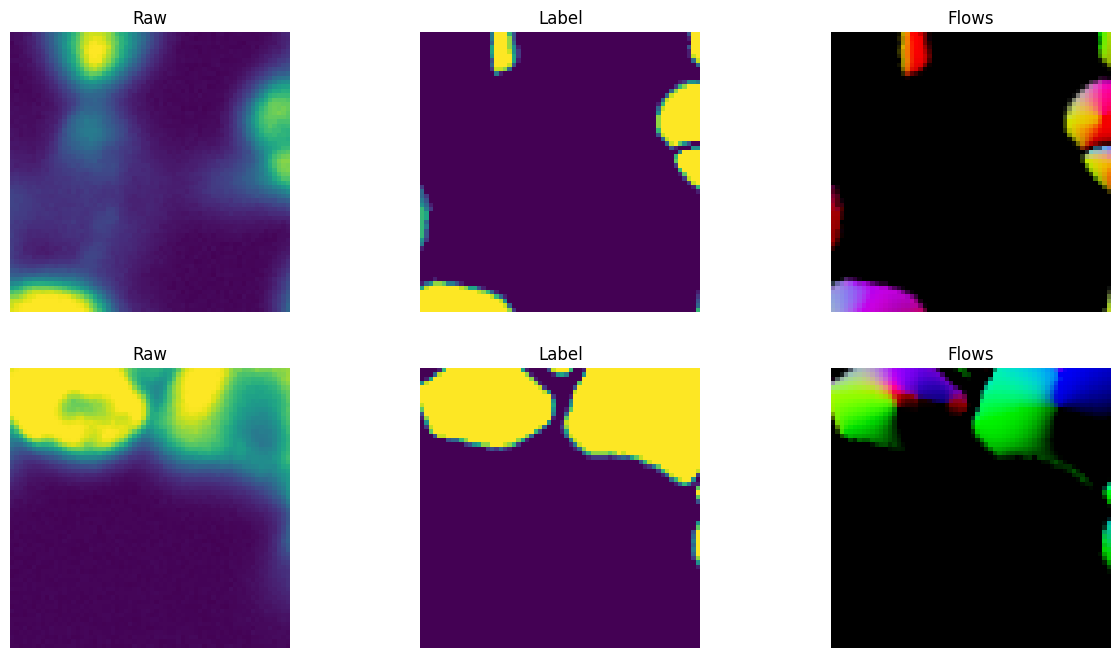

In [19]:

n_row = 2
fig, axes = plt.subplots(n_row, 3,sharex=False, sharey=False, figsize=(15,8))

slice2view = int(args.roi_z//2)
for i in range(n_row):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    # print(img2plot.shape, label2plot.shape)
    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()

    mask0= label2plot[0,0,:,:,slice2view].detach().cpu()
    # one flow
    flow= label2plot[0,1:4,:,:,slice2view].detach().cpu().numpy().transpose(1, 2, 0)

    # print(mask0.max(),mask0.min())
    # print('mask2',mask2.max(),mask2.min())
    axes[i,0].imshow(img2plot[0,0,:,:,slice2view])
    axes[i,0].set_title('Raw')
    
    axes[i,1].imshow(mask0)
    axes[i,1].set_title('Label')
    axes[i,2].imshow(flow)
    axes[i,2].set_title('Flows')

    for col in range(3):
      axes[i,col].axis('off')



In [18]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()